<a href="https://colab.research.google.com/github/ShaliniR8/lahman-mlb/blob/main/combined_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## imports

In [106]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn import compose
from sklearn import impute
from sklearn import decomposition
from sklearn import model_selection
from sklearn import tree
from sklearn import linear_model
from sklearn import metrics

In [ ]:
%%capture
!pip install xgboost
!pip install shap
import xgboost as xgb
import shap


In [ ]:
#@title Load Dataset

%%capture
# ---- filtered (only from 1910) 
# !wget https://github.com/ShaliniR8/lahman-mlb/raw/main/baseballdatabase.zip
# !unzip /content/baseballdatabase.zip -d "/content/"


#---- full
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/baseballdatabank_2022.zip
!unzip /content/baseballdatabank_2022.zip -d "/content/"

path = "/content/baseballdatabank-2022.2/core/"



In [107]:
batting = pd.read_csv(path + "Batting.csv")
pitching = pd.read_csv(path + "Pitching.csv")
people = pd.read_csv(path + "People.csv")
# fielding = pd.read_csv(path + "Fielding.csv")
teams = pd.read_csv(path + "Teams.csv")

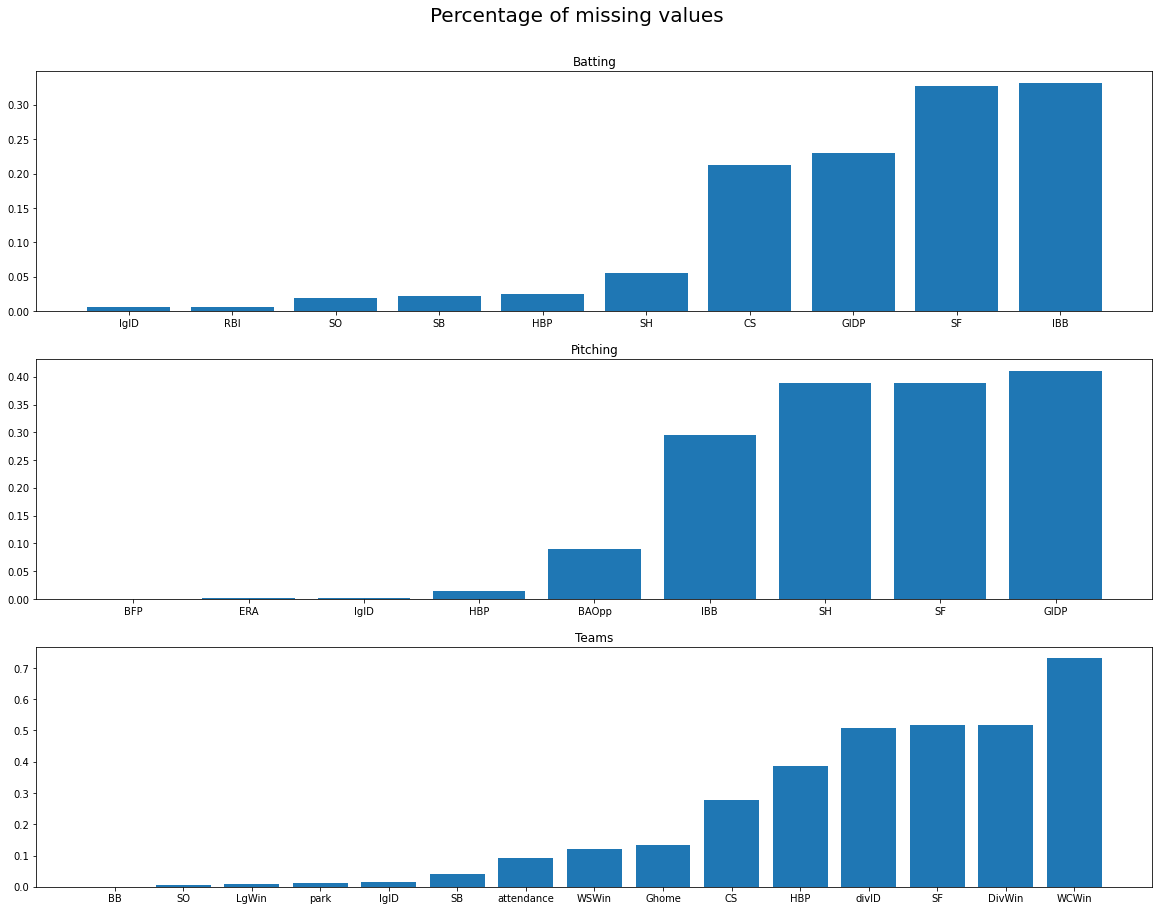

In [ ]:
#@title EDA
na_bat = batting.isna().sum().reset_index()
na_bat = na_bat[na_bat[0] > 0].sort_values(by = [0])
na_bat[0] = na_bat[0]/len(batting)

na_pit = pitching.isna().sum().reset_index()
na_pit = na_pit[na_pit[0] > 0].sort_values(by = [0])
na_pit[0] = na_pit[0]/len(pitching)

na_tea = teams.isna().sum().reset_index()
na_tea = na_tea[na_tea[0] > 0].sort_values(by = [0])
na_tea[0] = na_tea[0]/len(teams)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (20, 15))
ax1.bar(na_bat['index'], na_bat[0])
ax1.set_title('Batting')
ax2.bar(na_pit['index'], na_pit[0])
ax2.set_title('Pitching')
ax3.bar(na_tea['index'], na_tea[0])
ax3.set_title('Teams')
plt.suptitle('Percentage of missing values', size = 20, y= 0.94)
plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


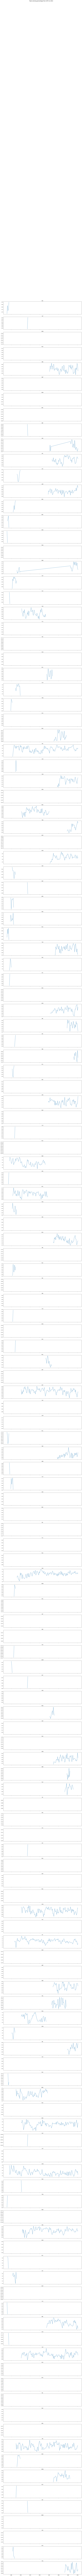

In [115]:
#@title EDA
def win_perc(team, year):
    team_year = teams[(teams['yearID'] == year) & (teams['teamID'] == team)]
    if team_year.empty:
        return np.nan
    team_year = team_year.iloc[0]
    w = team_year['W']
    l = team_year['L']
    return w / (w + l)

team_win_trend = teams[['yearID', 'teamID']]
team_win_trend['win_perc'] = team_win_trend.apply(lambda x: win_perc(x['teamID'], x['yearID']), axis=1)
team_win_trend.sort_values(by = 'yearID')
teamID_list = list(set(teams['teamID']))
m = len(teamID_list)
fig, axes = plt.subplots(m, 1, figsize = (20, 4*m), sharex=True)
for i, team in enumerate(teamID_list):
  x = team_win_trend[team_win_trend['teamID'] == team][['yearID']]
  y = team_win_trend[team_win_trend['teamID'] == team][['win_perc']]
  axes[i].plot(x, y)
  axes[i].set_title(team)

plt.suptitle('Team winning percentage from 1871 to 2021', size = 15)
plt.show()


## Dataset

In [ ]:
batting = batting[["playerID","yearID","teamID", "H", "BB", "HBP", "AB", "SF", "2B", "3B", "HR"]].copy()
pitching = pitching[["playerID","yearID","teamID", "ERA"]].copy()
people = people[['playerID', 'birthYear']].copy()
teams = teams[['teamID', 'yearID', 'W', 'L', 'R', 'RA', 'G', 'CS', 'SB', 'H', 'AB']].copy()
all_dfs = { 
    'batting': batting,
    'pitching': pitching,
    'people':people,
    # 'fielding':fielding,
    'teams':teams
}

## Cleaning

In [ ]:

def cleanX(X):
  categorical_features = X.select_dtypes("object").columns.to_list()
  numerical_features = X.select_dtypes(["int64", "float64"]).columns.to_list()
  knnImp = impute.KNNImputer(missing_values=np.nan)
  simpleImp = impute.SimpleImputer(strategy = 'median', missing_values=np.nan)
  Ximputer = compose.ColumnTransformer([
    ('categorical', knnImp, categorical_features),
    ('numerical', simpleImp, numerical_features)
  ])
  X_ = Ximputer.fit_transform(X)

  return X_

In [ ]:
for name,df in all_dfs.items():
  not_keys = list(set(df.columns.to_list()) - {'teamID', 'playerID'})
  keys = list(set(df.columns.to_list()) - set(not_keys))
  imputedX = pd.DataFrame(cleanX(df[not_keys]), columns = not_keys, dtype='int64')
  all_dfs[name] = pd.concat([df[keys], imputedX], axis = 1)
  print(name)
  print(all_dfs[name].info())
  


batting
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110495 entries, 0 to 110494
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   teamID    110495 non-null  object
 1   playerID  110495 non-null  object
 2   yearID    110495 non-null  int64 
 3   BB        110495 non-null  int64 
 4   SF        110495 non-null  int64 
 5   H         110495 non-null  int64 
 6   2B        110495 non-null  int64 
 7   AB        110495 non-null  int64 
 8   3B        110495 non-null  int64 
 9   HBP       110495 non-null  int64 
 10  HR        110495 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 9.3+ MB
None
pitching
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49430 entries, 0 to 49429
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   teamID    49430 non-null  object
 1   playerID  49430 non-null  object
 2   yearID    49430 non-null  int64 
 3   ERA    

In a future version, passing float-dtype values and an integer dtype to DataFrame will retain floating dtype if they cannot be cast losslessly (matching Series behavior). To retain the old behavior, use DataFrame(data).astype(dtype)


## Constructing Features

No need to run this after the feature is already constructed 

In [ ]:
def win_perc(team, year):
    team_year = teams[(teams['yearID'] == year) & (teams['teamID'] == team)]
    if team_year.empty:
        return np.nan
    team_year = team_year.iloc[0]
    w = team_year['W']
    l = team_year['L']
    return w / (w + l)


def get_rolling_win_perc (row):
    year = row['yearID']
    team = row['teamID']
    row['prev_year_win_perc'], row['rolling_3_win_perc'], row['rolling_5_win_perc'] = np.nan, np.nan, np.nan
    year1 = win_perc(team, year - 1)
    year2 = win_perc(team, year - 2)
    year3 = win_perc(team, year - 3)
    year4 = win_perc(team, year - 4)
    year5 = win_perc(team, year - 5)
    if (year1 == np.nan or year2 == np.nan or year3 == np.nan or year3 == np.nan or year4 == np.nan or year5 == np.nan):
      if (year1 == np.nan or year2 == np.nan or year3 ==np.nan):
        if year1 == np.nan: 
          return row
        else:
          row['prev_year_win_perc'] = year1
          return row
      else:
        row['prev_year_win_perc'], row['rolling_3_win_perc'] = year1,  (year1 + year2 + year3)/3
        return row
    else:
      row['prev_year_win_perc'], row['rolling_3_win_perc'], row['rolling_5_win_perc']  = year1,  (year1 + year2 + year3)/3, (year1 + year2 + year3 + year4 + year5)/5
      return row

def get_pwp(row):
    R = row['R']
    RA = row['RA']
    G = row['G']
    year = row['yearID'] - 1
    team = row['teamID']
    row['pwp'] = np.nan
    new_row = teams[(teams['yearID'] == year) & (teams['teamID'] == team)]
    if new_row.empty: return row
    new_row = new_row.iloc[0]
    row['pwp_1.83'] = np.power((R + RA)/G, 1.83)
    row['pwp_0.285'] = np.power((R + RA)/G, 0.285)
    return row

def get_CS_perc(row):
    CS = row['CS']
    SB = row['SB']
    year = row['yearID'] - 1
    team = row['teamID']
    row['CS_perc'] = np.nan
    new_row = teams[(teams['yearID'] == year) & (teams['teamID'] == team)]
    if new_row.empty: return row
    new_row = new_row.iloc[0]
    row['CS_perc'] = CS/SB
    return row

def get_BA(row):
    # batting average
    H = row['H']
    AB = row['AB']
    year = row['yearID'] - 1
    team = row['teamID']
    row['BA'] = np.nan
    new_row = teams[(teams['yearID'] == year) & (teams['teamID'] == team)]
    if new_row.empty: return row
    new_row = new_row.iloc[0]
    row['BA'] = H/AB
    return row

In [ ]:
def get_age(row):
  playerID = row['playerID']
  yearID = row['yearID']
  birthYear = people[people['playerID'] == playerID]['birthYear']
  birthYear = birthYear.iloc[0]
  age = yearID - birthYear
  row['age'] = age
  return row

In [ ]:
def ops_calc(row):
  #calc done on rows of batting table
  if row['AB'] == 0:
      return np.nan
  HBP = row["HBP"]
  SF = row["SF"]
  singles = row["H"] - row["2B"] - row["3B"] - row["HR"]
  obp = (row["H"] + row["BB"] + HBP) / (row["AB"] + row["BB"] + SF + HBP)
  slug = (singles + (2 * row["2B"]) + (3 * row["3B"]) + (4 * row["HR"])) / row["AB"]
 
  return slug + obp 

def get_ops(row):
  year = row['yearID'] - 1
  team = row['teamID']
  player = row["playerID"]
  row['ops'] = np.nan
  filtered_df = batting[(batting['yearID'] == year) & (batting['teamID'] == team) & (batting['playerID'] == player)]
  if filtered_df.empty:
      return row
  filtered_df = filtered_df.iloc[0]
  row['ops'] = ops_calc(filtered_df)
  return row

In [ ]:
teams = all_dfs['teams']
pitching = all_dfs['pitching']
people = all_dfs['people']
batting = all_dfs['batting']

In [ ]:
# teams winning perc
t_features = teams.apply(lambda x: get_rolling_win_perc(x), axis = 1)
t_features = t_features.apply(lambda x: get_pwp(x), axis = 1)
t_features = t_features.apply(lambda x: get_CS_perc(x), axis = 1)
t_features = t_features.apply(lambda x: get_BA(x), axis = 1).drop(columns = ['pwp', 'W', 'L', 'G', 'R', 'RA', 'CS', 'SB', 'H', 'AB'])

In [ ]:
t_features.to_csv('t_features.csv')

In [ ]:
#pitcher ages
ages = pitching.apply(lambda x: get_age(x), axis = 1).copy()

In [ ]:
#median era and mean pitching age
p_features = ages.groupby(['teamID', 'yearID']).agg({'ERA':'median', 
                                                            'age':'mean'}).reset_index()
p_features = p_features.rename(columns = {"ERA": "medianERA", 'age': 'pitcherAverageAge'})

In [ ]:
#batter ages
ages = batting.apply(lambda x: get_age(x), axis = 1).copy()

In [ ]:
ops = ages.apply(lambda x: get_ops(x), axis=1).copy()

In [ ]:
#median ops and average age

b_features = ops.groupby(['teamID', 'yearID']).agg({'age':'mean', 
                                                            'ops':'median'}).reset_index()
b_features = b_features.rename(columns = {"age": "batterAverageAge", "ops": "medianOPS"})



## Load constructed features and targets

In [ ]:
%%capture
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/b_features.csv 
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/p_features.csv 
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/t_features.csv 

In [99]:
b_features = pd.read_csv('/content/b_features.csv').drop(columns = ['Unnamed: 0'])
p_features = pd.read_csv('/content/p_features.csv').drop(columns = ['Unnamed: 0'])
t_features = pd.read_csv('/content/t_features.csv').drop(columns = ['Unnamed: 0'])
t_features = t_features[t_features['yearID'] > min(t_features['yearID'])]
t_features.shape, b_features.shape

((2976, 9), (2985, 4))

In [100]:
cols_to_merge_on = list(set(t_features.columns).intersection(set(p_features.columns)))
print(cols_to_merge_on)
temp1 = pd.merge(t_features, p_features, how='inner', left_on = cols_to_merge_on, right_on = cols_to_merge_on)

['teamID', 'yearID']


In [101]:
cols_to_merge_on = list(set(b_features.columns).intersection(set(temp1.columns)))
features = pd.merge(temp1, b_features, how='inner', left_on=cols_to_merge_on, right_on=cols_to_merge_on)
#dropping the first year because all columns except id are empty
y_teams = teams[teams['yearID'] > min(teams['yearID'])].reset_index()
y = y_teams.apply(lambda y: y['W']/ (y['W'] + y['L']), axis=1)
y = list(y)
features.shape, len(y)

((2976, 13), 2976)

## preprocess

In [ ]:
ohe = preprocessing.OneHotEncoder()
ss = preprocessing.StandardScaler()
year_array = list(set(features['yearID']))
year_array.sort()
mm = preprocessing.MinMaxScaler(feature_range=(0, len(set(features['yearID']))-1))

In [ ]:
fcols = list(features.columns)
fcols.remove('teamID')
fcols.remove('yearID')
print(fcols)

['prev_year_win_perc', 'pwp_0.285', 'pwp_1.83', 'rolling_3_win_perc', 'rolling_5_win_perc', 'CS_perc', 'BA', 'medianERA', 'pitcherAverageAge', 'batterAverageAge', 'medianOPS']


In [ ]:
# perctages and ages std scaled
features_ss = ss.fit_transform(features[fcols])
features[fcols] = features_ss

In [ ]:
# scaling down year
ymm = mm.fit_transform(features[['yearID']]).astype('int64')
ymm = ymm.reshape(1, -1)[0]
features['yearID'] = pd.Series(ymm)

In [ ]:
# one hot encoding teamID
teamID = features[['teamID']]
teamID_ohe = ohe.fit_transform(teamID)
tid_names = list(ohe.get_feature_names_out())
teamID_df = pd.DataFrame(teamID_ohe.toarray(), columns= tid_names, dtype = 'int64')
features = features.drop(columns = ['teamID'])
X = pd.concat([teamID_df, features], axis = 1)

In [ ]:
print(X.shape, len(y))
X.head()

(2976, 158) 2976


,teamID_ALT,teamID_ANA,teamID_ARI,teamID_ATL,teamID_BAL,teamID_BFN,teamID_BFP,teamID_BL1,teamID_BL2,teamID_BL3,...,pwp_1.83,rolling_3_win_perc,rolling_5_win_perc,yearID,CS_perc,BA,medianERA,pitcherAverageAge,batterAverageAge,medianOPS
0,0,0,0,0,0,0,0,1,0,0,...,NaN,NaN,NaN,0,NaN,NaN,-1.736156,-1.062462,-1.527248,NaN
1,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,0,NaN,NaN,4.260342,-11.185544,-6.222553,NaN
2,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,0,NaN,NaN,0.444389,-32.248087,-13.110602,NaN
3,0,0,0,0,0,0,0,0,0,0,...,5.150994,NaN,NaN,0,-1.058460,3.239081,-2.281292,0.570293,-0.794024,0.879553
4,0,0,0,0,0,0,0,0,0,0,...,8.999966,NaN,NaN,0,-1.217624,1.591295,1.534661,-0.463785,-1.602838,0.667606


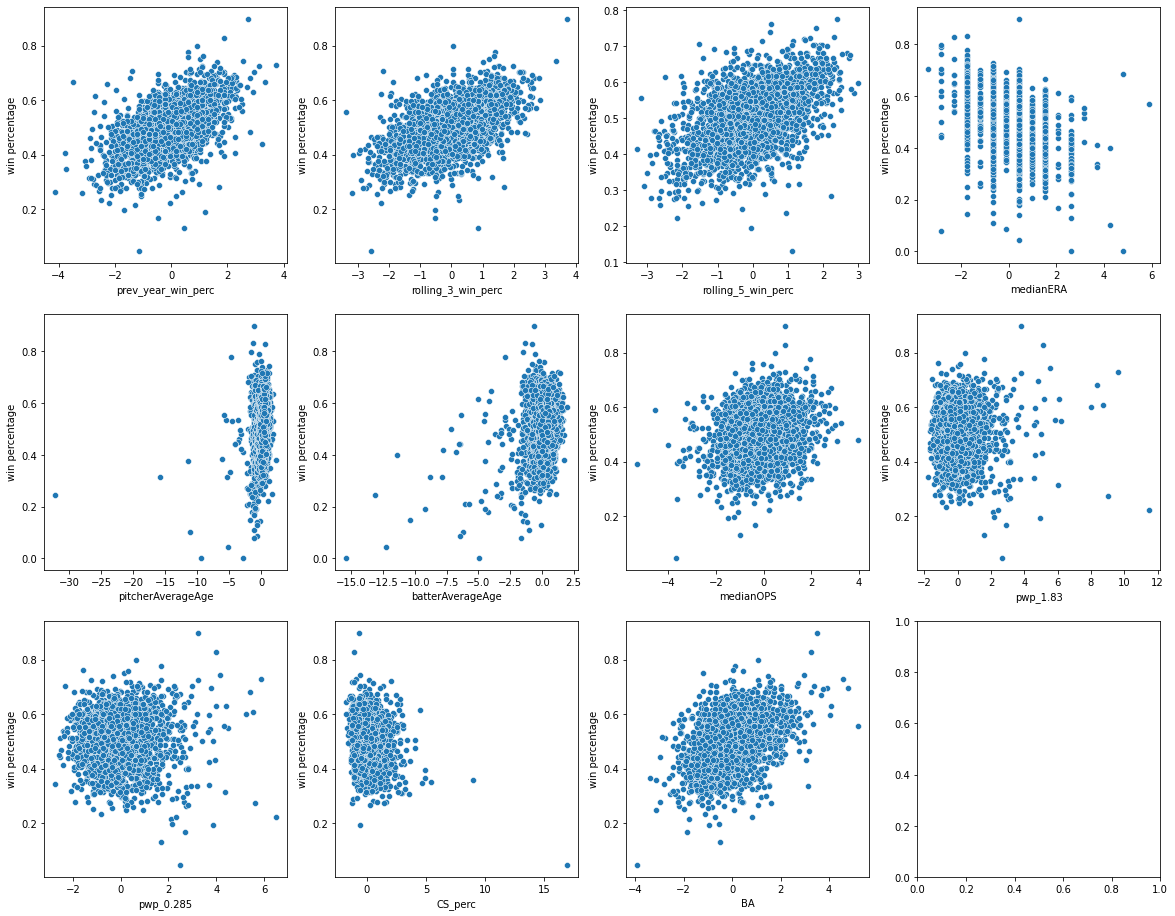

In [ ]:
columns = ['prev_year_win_perc', 'rolling_3_win_perc',
       'rolling_5_win_perc', 'medianERA', 'pitcherAverageAge',
       'batterAverageAge', 'medianOPS', 'pwp_1.83', 'pwp_0.285', 'CS_perc', 'BA']
import seaborn as sns

n = 4
m = int(np.ceil(len(columns)/n))
c = 0
fig, axes = plt.subplots(m,n, figsize = (20, 4*n))
for i in range(m):
  for j in range(n):
    if c>= len(columns): break
    sns.scatterplot(x = X[columns[c]], y = y, ax=axes[i,j])
    axes[i, j].set_ylabel('win percentage')
    c += 1
    
plt.show()

## Test/ train

In [ ]:
#@title custom train test split
def train_test_split(X, y, train_size):
  # produces time separated test and train split of roughly the train_size passed into this method
  X_train, y_train = pd.DataFrame(), []
  X_test, y_test = pd.DataFrame(), []
  train_size = int(X.shape[0]*train_size)
  counts = X.groupby(['yearID'], sort=True)['yearID'].count()
  years_mm = list(set(X['yearID']))
  years_mm.sort()
  for i, count in enumerate(counts):
    X_train_ = X[X['yearID'] == i]
    idx = X_train_.index
    y_train_ = np.array(y)[idx]
    years_mm.pop(0)
    X_train = pd.concat([X_train, X_train_])
    y_train += list(y_train_)
    if X_train.shape[0] >= train_size:
      break

  for year in years_mm:
    X_test_ = X[X['yearID'] == year]
    idx = X_test_.index
    y_test_ = np.array(y)[idx]
    X_test = pd.concat([X_test, X_test_])
    y_test += list(y_test_)

  return (X_train, X_test, y_train, y_test)


In [ ]:
from sklearn import dummy 

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
clf = dummy.DummyRegressor(strategy='mean')
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

-0.0006997362622029879

## Model

In [ ]:
# boost regression
reg_xgb = xgb.XGBRegressor(objective = 'reg:squarederror')
reg_xgb.fit(X_train,y_train)

XGBRegressor(objective='reg:squarederror')

## Cross validation

In [ ]:
#@title custom cross validation
# cross val

def cross_val(model, X_train, y_train, cv):
  n_years = len(set(X_train['yearID']))
  years = list(set(X_train['yearID']))
  years.sort()
  k = cv
  if n_years%2 != k%2: k -= 1
  print('k :', k) 
  size_k = int(n_years/k)
  splits = {}
  j = 0
  for i in range(k):
    splits[i] = years[j:j+size_k]
    j = j+size_k

  X_val_train_set = {}
  y_val_train_set = {}
  X_val_test_set = {}
  y_val_test_set = {}

  min_train_size = X_train.shape[0]
  min_test_size = X_test.shape[0]
  for i in range(k):
    val_set = splits[i]
    start_year = val_set[0]
    end_year = val_set[size_k - 1]
    
    X_val_test = X_train[(X_train['yearID'] >= start_year) & (X_train['yearID'] <= end_year)].copy()
    idx = X_val_test.index
    if len(idx) < min_test_size: min_test_size = len(idx)
    y_val_test = np.array(y)[idx]

    up = X_train[(X_train['yearID'] < start_year)]
    up = None if up.empty else up
    do = X_train[(X_train['yearID'] > end_year)]
    do = None if do.empty else do
    X_val_train =  pd.concat([up, do]).copy()
    idx = X_val_train.index
    if len(idx) < min_train_size: min_train_size = len(idx)
    y_val_train = np.array(y)[idx]

    X_val_test_set[i] = X_val_test
    X_val_train_set[i] = X_val_train
    y_val_test_set[i] = y_val_test
    y_val_train_set[i] = y_val_train

  scores = []
  min_test_size1 = int(min_train_size/k)
  min_test_size = min(min_test_size, min_test_size1)
  min_train_size = k*min_test_size
  for i in range(k):
    random_scores = []
    for j in range(3):
      idx_train = np.array(list(X_val_train_set[i].index)) 
      np.random.seed(j)
      selected_idx = np.random.choice(len(idx_train), replace = False, size = min_train_size)
      y_val_train = y_val_train_set[i][selected_idx]
      selected_idx = idx_train[selected_idx]
      X_val_train = X_val_train_set[i].loc[selected_idx]

      idx_test = np.array(list(X_val_test_set[i].index)) 
      selected_idx = np.random.choice(len(idx_test), replace = False, size = min_test_size)
      y_val_test = y_val_test_set[i][selected_idx]
      selected_idx = idx_test[selected_idx]
      X_val_test = X_val_test_set[i].loc[selected_idx]
    
      model.fit(X_val_train, y_val_train)
      y_val_pred = model.predict(X_val_test)
      score = metrics.mean_absolute_error(y_val_test, y_val_pred)
      random_scores.append(score)
    scores.append(np.mean(random_scores))

  return np.array(scores)
    

In [ ]:
score = cross_val(reg_xgb, X_train, y_train, 3).mean()
print('MAE_cv score: ', round(score, 5))

print('\nFeature Selection')
sel = feature_selection.VarianceThreshold(threshold=0.01)
sel.fit(X_train)
quasi_constant_cols = [ x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]
print("quasi constant features: ", quasi_constant_cols)
X_train_1 = X_train.drop(columns=quasi_constant_cols)

score = cross_val(reg_xgb, X_train_1, y_train, 3).mean()
print('MAE_cv score: ', round(score, 5))


k : 3
MAE_cv score:  0.0563

Feature Selection
quasi constant features:  ['teamID_ALT', 'teamID_ANA', 'teamID_ARI', 'teamID_BFN', 'teamID_BFP', 'teamID_BL1', 'teamID_BL2', 'teamID_BL3', 'teamID_BL4', 'teamID_BLA', 'teamID_BLF', 'teamID_BLN', 'teamID_BLU', 'teamID_BR1', 'teamID_BR2', 'teamID_BR3', 'teamID_BR4', 'teamID_BRF', 'teamID_BRP', 'teamID_BS1', 'teamID_BS2', 'teamID_BSP', 'teamID_BSU', 'teamID_BUF', 'teamID_CH2', 'teamID_CHF', 'teamID_CHP', 'teamID_CHU', 'teamID_CL1', 'teamID_CL2', 'teamID_CL3', 'teamID_CL4', 'teamID_CL5', 'teamID_CL6', 'teamID_CLP', 'teamID_CN1', 'teamID_CN2', 'teamID_CN3', 'teamID_CNU', 'teamID_COL', 'teamID_DTN', 'teamID_ELI', 'teamID_FLO', 'teamID_HAR', 'teamID_HR1', 'teamID_IN1', 'teamID_IN2', 'teamID_IN3', 'teamID_IND', 'teamID_KC1', 'teamID_KC2', 'teamID_KCF', 'teamID_KCN', 'teamID_KCU', 'teamID_KEO', 'teamID_LAA', 'teamID_LS1', 'teamID_LS2', 'teamID_LS3', 'teamID_MIA', 'teamID_MID', 'teamID_MIL', 'teamID_ML1', 'teamID_ML2', 'teamID_ML3', 'teamID_MLA', 't

In [ ]:
X_fs = X.drop(columns=quasi_constant_cols)
X_train, X_test, y_train, y_test = train_test_split(X_fs, y, train_size=0.8)


## Testing

In [ ]:
reg_xgb = xgb.XGBRegressor(objective = 'reg:squarederror')
reg_xgb.fit(X_train,y_train)

XGBRegressor(objective='reg:squarederror')

In [ ]:
y_pred = reg_xgb.predict(X_test)
score = reg_xgb.score(X_test, y_test, )
print(score)

0.48348158380821293


## Result visualization

In [ ]:
tidNames_X_test = X.loc[X_test.index][tid_names]
inv = list(ohe.inverse_transform(tidNames_X_test).reshape(1,-1))[0]
test_years = list(X_test['yearID'])

result_df = pd.DataFrame()
result_df['yearID'] = np.array(year_array)[test_years]
result_df['teamID'] = inv
result_df['win_prob_pred'] = list(y_pred)
result_df['win_prob_pred'] *= 100
result_df['win_prob_actual'] = list(y_test)
result_df['win_prob_actual'] *= 100


result_df.head()

,yearID,teamID,win_prob_pred,win_prob_actual
0,2003,ANA,54.212040,47.530864
1,2003,ARI,53.455673,51.851852
2,2003,ATL,62.957645,62.345679
3,2003,BAL,46.226986,43.827160
4,2003,BOS,54.997765,58.641975


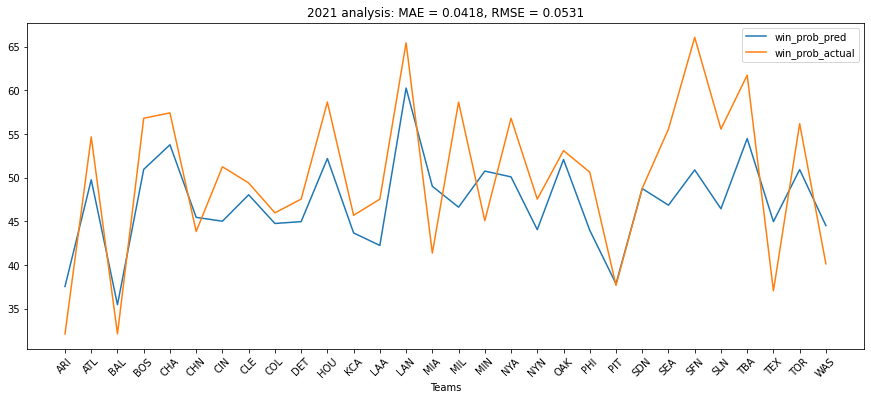

In [ ]:
#@title graph for 2021 
mae = metrics.mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
result_df_2021 = result_df[result_df['yearID'] == 2021 ]
plt.figure(figsize = (15,6))
plt.plot(result_df_2021['teamID'], result_df_2021['win_prob_pred'], label = 'win_prob_pred')
plt.plot(result_df_2021['teamID'], result_df_2021['win_prob_actual'], label = 'win_prob_actual')
plt.title(f'2021 analysis: MAE = {round(mae, 4)}, RMSE = {round(rmse, 4)}')
plt.xlabel('Teams')
plt.xticks(rotation=45)
plt.legend()
plt.show()

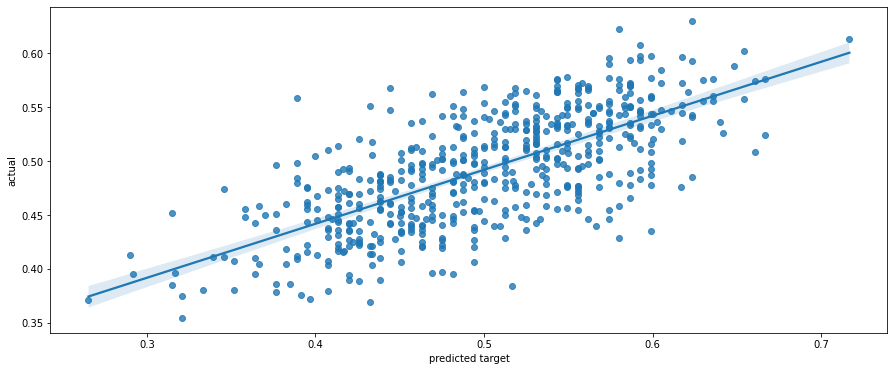

In [ ]:
#@title predicted vs actual

import seaborn as sns

plt.figure(figsize=(15, 6))
sns.regplot(x = y_test, y = y_pred)
plt.xlabel('predicted target')
plt.ylabel('actual')
plt.show()

#### shap import and values

In [ ]:
explainer = shap.Explainer(reg_xgb)
shap_values = explainer(X_test)

#### plots

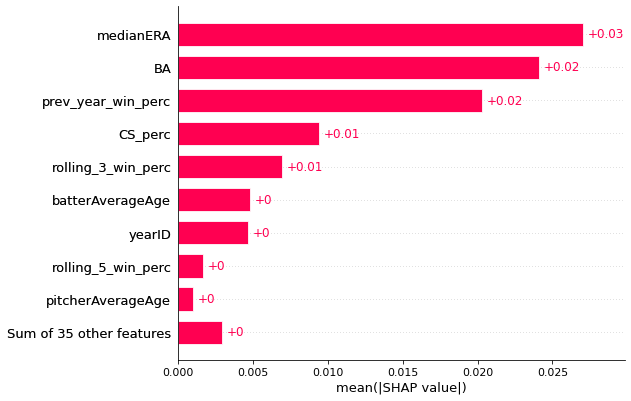

In [ ]:
shap.plots.bar(shap_values, max_display=10) 

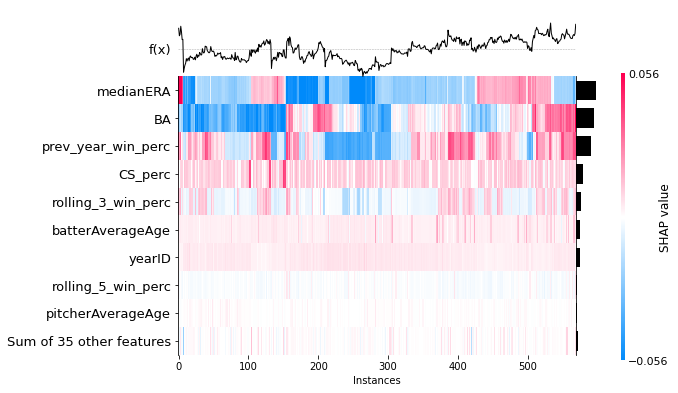

In [ ]:

shap.plots.heatmap(shap_values)

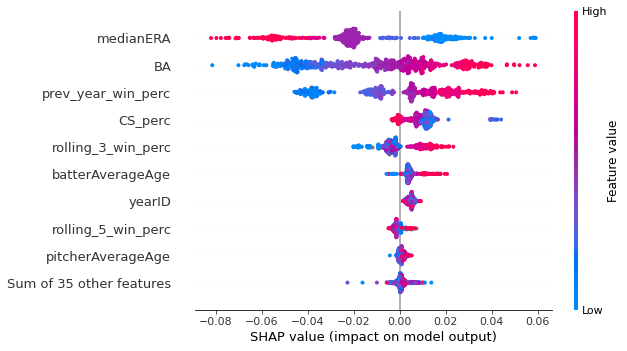

In [ ]:
shap.plots.beeswarm(shap_values)

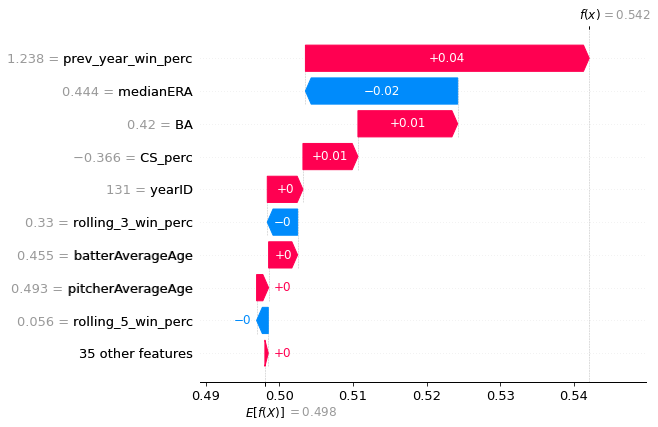

In [ ]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

## other basic models 

In [ ]:
imputer_mean = impute.SimpleImputer()
X_train_ = imputer_mean.fit_transform(X_train)
X_test_ = imputer_mean.transform(X_test)

In [ ]:
#@title linear regression

reg1 = linear_model.LinearRegression()
reg1.fit(X_train_, y_train)
y_pred1 = reg1.predict(X_test_)
print(metrics.r2_score(y_test, y_pred1))

0.4976869178993616


In [ ]:
#@title decision tree
reg2 = tree.DecisionTreeRegressor()
reg2.fit(X_train_, y_train)
y_pred2 = reg2.predict(X_test_)
print(metrics.r2_score(y_test, y_pred2))

-0.10608246409122635
